In [1]:
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Grayscale
from torchvision.datasets import MNIST, CIFAR10 
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

%autoreload 2
from networks import *
from utils import *
from losses import *
from landscape import *
from datasets import *

import matplotlib.pyplot as plt

## Training Setup

In [2]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=2
dims_latent = 32                            
learning_rate=1e-3
batch_size=16                                        
device=set_device("cuda", 0)
train_size=0.00108

# Losses
l2loss    = nn.MSELoss(reduction="sum")
awi1D     = AWLoss1DFFT(reduction="sum", std=3e-4, store_filters="norm", epsilon=3e-15)
awi2D     = AWLoss2DFFT(reduction="sum", std=3e-4, store_filters="norm", epsilon=3e-15)


No GPU available! Running on CPU


## Datasets and Dataloaders

In [3]:
# Train Transforms
train_transform = Compose([
    Resize(28),
    # Grayscale(),
])

# Datasets and dataloaders
ds = CIFAR10("../data", download=True, train=True, transform=train_transform)

try:
    shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
    train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]
except:
    train_idx=[7]

X_train, y_train = torch.from_numpy(ds.data[train_idx]) / 255., torch.tensor(ds.targets)[train_idx]
X_train = X_train.permute(0, 3, 1, 2)
trainds = TransformTensorDataset(X_train.float(), y_train.float(), transform=train_transform)

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)

X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())

Files already downloaded and verified
Trainable Images: 54
torch.Size([1, 3, 28, 28]) 0.014325735159218311 1.0


## Autoencoder (CNN)

In [4]:
def model_instance():
    return CAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)

model_sample = model_instance()

print(model_sample)
print(X.shape, model_sample(X).shape)

CAE28(
  (activation): Mish()
  (sigmoid): Sigmoid()
  (e_cv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
  (e_cv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (e_cv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
  (e_fc5): Linear(in_features=128, out_features=32, bias=True)
  (d_fc1): Linear(in_features=32, out_features=128, bias=True)
  (d_cv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(3, 3))
  (d_cv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(3, 3))
  (d_cv4): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(3, 3))
)
torch.Size([1, 3, 28, 28]) torch.Size([1, 3, 28, 28])


## Training MSE Loss



Training started ...


N/A% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 {'epoch': 0, 'loss': 2198.92626953125, 'mse (validation)': 0.06863796710968018, 'kl_loss': 0.0}


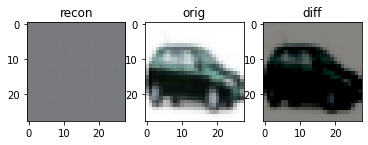

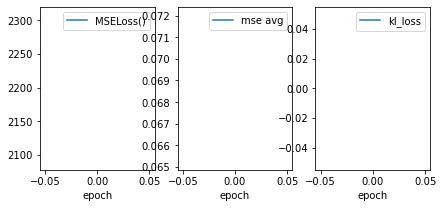

 50% (1 of 2) |#############             | Elapsed Time: 0:00:02 ETA:   0:00:02Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 {'epoch': 1, 'loss': 2192.6923828125, 'mse (validation)': 0.06726142019033432, 'kl_loss': 0.0}


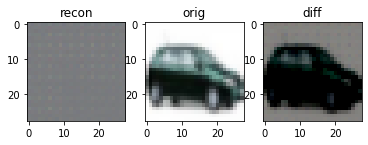

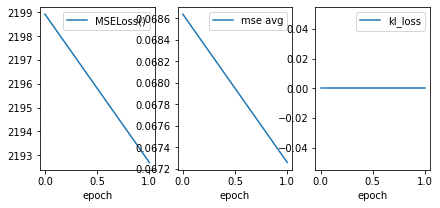

100% (2 of 2) |##########################| Elapsed Time: 0:00:02 Time:  0:00:02


In [5]:
model = model_instance()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, train_loader, l2loss, nepochs, log_frequency=20, sample=X, device=device, gradflow=False)

### Loss Landscape

In [6]:
# train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=16)))
# train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
# print("Train Subset len: ", len(train_subset))
# xx, yy, loss_landscape = visualise_landscape(model, train_subloader, awi1D, device=device)

## Training AWLoss1D



Training started ...


N/A% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 {'epoch': 0, 'loss': 2.461822986602783, 'mse (validation)': 0.06888145953416824, 'kl_loss': 0.0}
 argidx T, v:  2351 2351


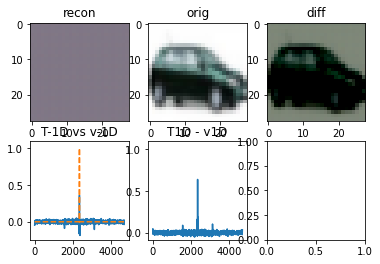

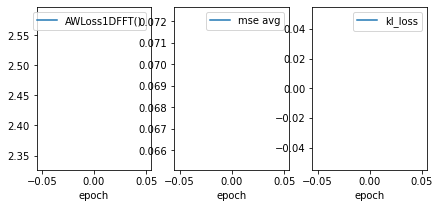

 50% (1 of 2) |#############             | Elapsed Time: 0:00:02 ETA:   0:00:02Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 {'epoch': 1, 'loss': 2.450793504714966, 'mse (validation)': 0.06756323575973511, 'kl_loss': 0.0}
 argidx T, v:  2351 2351


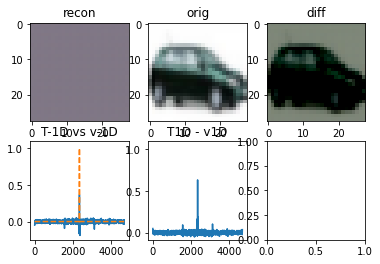

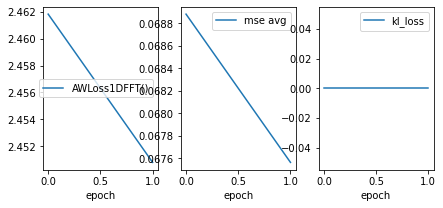

100% (2 of 2) |##########################| Elapsed Time: 0:00:03 Time:  0:00:03


In [7]:
model = model_instance()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, train_loader, awi1D, nepochs, log_frequency=20, sample=X, device=device, gradflow=False)

### Loss Landscape

In [8]:
# train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=16)))
# train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
# print("Train Subset len: ", len(train_subset))
# xx, yy, loss_landscape = visualise_landscape(model, train_subloader, awi1D, device=device)

## Training AWLoss2D



Training started ...


/opt/anaconda3/envs/mltorch/lib/python3.9/site-packages/torch/autograd/__init__.py:147: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:240.)
  Variable._execution_engine.run_backward(
N/A% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 {'epoch': 0, 'loss': 3.7185282707214355, 'mse (validation)': 0.06925924122333527, 'kl_loss': 0.0}
 argidx T, v:  1512 4537


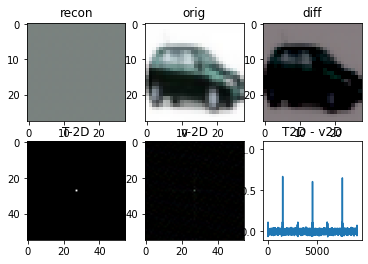

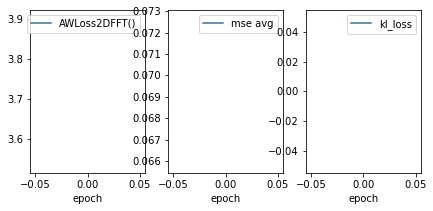

 50% (1 of 2) |#############             | Elapsed Time: 0:00:02 ETA:   0:00:02Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 {'epoch': 1, 'loss': 3.677042007446289, 'mse (validation)': 0.0663611963391304, 'kl_loss': 0.0}
 argidx T, v:  1512 4537


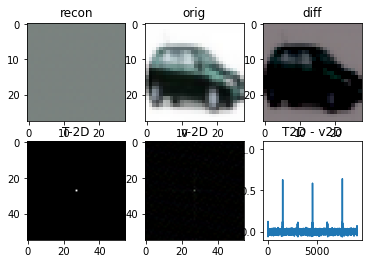

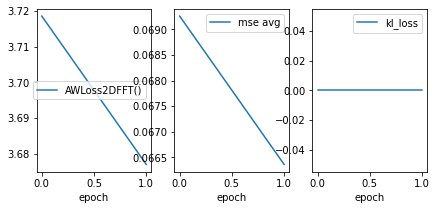

100% (2 of 2) |##########################| Elapsed Time: 0:00:02 Time:  0:00:02


In [9]:
model = model_instance()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, train_loader, awi2D, nepochs, log_frequency=20, sample=X, device=device, gradflow=False)

### Loss Landscape

In [10]:
# train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=16)))
# train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
# print("Train Subset len: ", len(train_subset))
# xx, yy, loss_landscape = visualise_landscape(model, train_subloader, awi1D, device=device)